# Initialization

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

# Load Data

In [5]:
df_rvalue = pd.read_csv('data/infered_rvalue.csv')
df_rvalue.date = pd.to_datetime(df_rvalue.date, format='%Y-%m-%d')
df_rvalue.head()

,date,R_t
0,2020-07-31,1.633441
1,2020-08-01,1.636637
2,2020-08-02,1.639839
3,2020-08-03,1.643047
4,2020-08-04,1.646260


In [25]:
start_train = '2020-08-01'
df, _, _, _, _, _ = get_cluster_data(n_cluster=2, method='kmeans', cov_type='full', cluster_input_data='fa_data', start_train=start_train, end_train='2020-12-01', start='2020-07-21')
df.head()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,gender,postnr,region,Q1_1_feel_exposed,Q1_2_covid_is_threat,...,Q16_Unsure_of_party_choice,Q16_Venstre,Vaccination_Status,Willingness_Vaccination,Q4_1_nr_contact_nonhouse_family,Q4_2_nr_contact_colleagues,Q4_3_nr_contact_friends,Q4_4_nr_contact_strangers,Q7_last_week_symptom,group
0,1.000000,0.819706,0.916667,0.250000,0.555556,1,4654,Zealand,3.0,7.0,...,0,0,NaN,NaN,0,0,2,2,0,0
1,0.875000,0.666667,0.291667,0.416667,0.611111,0,4700,Zealand,6.0,6.0,...,0,0,NaN,NaN,4,1,4,15,0,1
2,0.708333,0.083333,0.041667,0.666667,0.111111,0,4000,Zealand,2.0,5.0,...,1,0,NaN,NaN,4,0,0,1,0,1
3,1.000000,0.972222,0.750000,0.833333,0.611111,0,8543,Central,4.0,4.0,...,0,0,NaN,NaN,0,0,0,0,1,0
4,0.958333,0.916667,0.958333,1.000000,0.500000,1,3760,Capital,2.0,1.0,...,0,0,NaN,NaN,0,0,1,0,0,0


In [26]:
group_nr = 1
df_group = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = df_group[df_group['date']==row['date']]['gender'].sum()
  return row['gender']/sum
df_group['percentage'] = df_group.apply(lambda x: normalize(x), axis=1)
df_group.drop(columns='gender',inplace=True)
df_group = df_group[df_group['group'] == group_nr].reset_index(drop=True)
df_group = df_group.groupby('date').mean().rolling(7).mean().reset_index()
df_group = df_group.dropna().reset_index(drop=True)
df_group = df_group[df_group.date >= start_train]
df_group.head()

,date,group,percentage
5,2020-08-01,1.0,0.423189
6,2020-08-02,1.0,0.416922
7,2020-08-03,1.0,0.417142
8,2020-08-04,1.0,0.424950
9,2020-08-05,1.0,0.426723


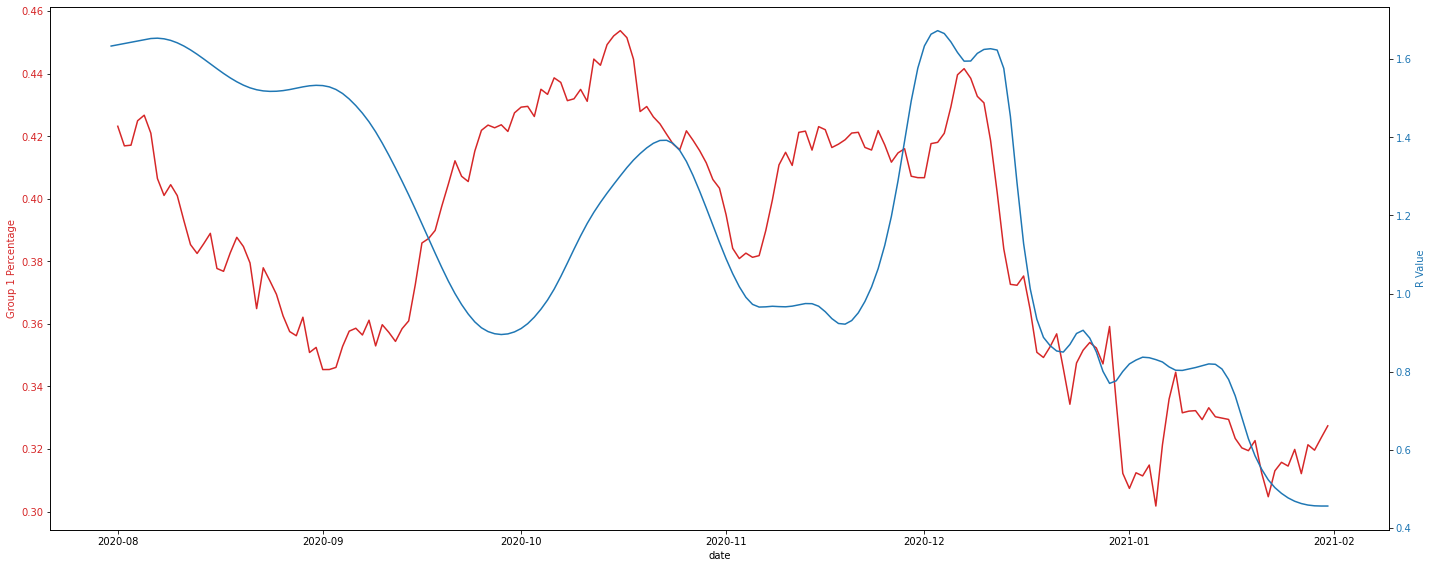

In [27]:
fig, ax1 = plt.subplots(figsize=(20, 8))
df_group['percentage_transformed'] = np.exp(df_group['percentage'])
color = 'tab:red'
ax1.set_xlabel('date')
ax1_ylabel = 'Group ' + str(group_nr) + ' Percentage'
ax1.set_ylabel(ax1_ylabel, color=color)
ax1.plot(df_group['date'], df_group['percentage'], color=color)
#ax1.plot(df_group['date'], df_group['percentage_transformed'], color='grey')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R Value', color=color)  # we already handled the x-label with ax1
ax2.plot(df_rvalue['date'], df_rvalue['R_t'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()